# Stock analysis

## Import

Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict as dd
import yfinance as yf
from fpdf import FPDF

from functions.analyse_price import *
from functions.params import index_tickers

## Get data

Run data

In [2]:
TICKER = 'CSL'
first_end_of_quarter = '2020-06'
last_end_of_quarter = '2024-06'
historical_prices = {}

In [3]:
asx_companies_directory = pd.read_csv('../data/asx_companies_directory.csv')
asx_companies_directory['Market Cap'] = asx_companies_directory['Market Cap'].apply(
    lambda x: float(x) if x.isnumeric() else float(x.lower()) if 'E+' in x else np.nan)

In [4]:
gics = pd.read_csv('../data/asx_gics.csv')

# Define a dictionary mapping tickers to their corresponding sector and industry
updates = {
    'NWSLV.AX': {'Sector': 'Communication Services', 'Industry': 'Entertainment'},
    'KKC.AX': {'Sector': 'Financials', 'Industry': 'Diversified Financials'},
    'PCI.AX': {'Sector': 'Financials', 'Industry': 'Diversified Financials'},
    'RF1.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'},
    'RG8.AX': {'Sector': 'Information Technology', 'Industry': 'Software'},
    'VG1.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'},
    'WQG.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'}
}

# Update the DataFrame based on the mapping
for ticker, data in updates.items():
    gics.loc[gics['Ticker'] == ticker, 'Sector'] = data['Sector']
    gics.loc[gics['Ticker'] == ticker, 'Industry'] = data['Industry']


gics['Industry'] = gics['Industry'].apply(lambda x: ''.join(
    str(x).split('-')).replace(' ', '').replace('—', ''))

gics['Sector'] = gics['Sector'].apply(lambda x: ''.join(
    str(x).split('-')).replace(' ', '').replace('—', ''))

In [5]:
# all companies in the top 500
top_500 = asx_companies_directory.sort_values(
    'Market Cap', ascending=False).head(500)['ASX code'].values + '.AX'

# get all companies with market cap above 1 billion
above_1b = asx_companies_directory[asx_companies_directory['Market Cap']
                                   >= 1000000000]['ASX code'].values + '.AX'

In [6]:
def find_similar_type_tickers(gics_type: str, gics_name: str, comparable_universe: list) -> list:
    same_gics_tickers = gics[(gics[gics_type] == gics_name) & (
        gics['Ticker'].isin(comparable_universe))]['Ticker'].values

    return same_gics_tickers

In [7]:
# find same industry stocks
ticker_gics_sector = gics[gics['Ticker'] == f'{TICKER}.AX']['Sector'].values[0]
ticker_gics_industry = gics[gics['Ticker']
                            == f'{TICKER}.AX']['Industry'].values[0]

In [8]:
same_sector_1bn = find_similar_type_tickers(
    gics_type='Sector', gics_name=ticker_gics_sector, comparable_universe=above_1b)
same_industry_1bn = find_similar_type_tickers(
    gics_type='Industry', gics_name=ticker_gics_industry, comparable_universe=above_1b)
same_sector_500 = find_similar_type_tickers(
    gics_type='Sector', gics_name=ticker_gics_sector, comparable_universe=top_500)
same_industry_500 = find_similar_type_tickers(
    gics_type='Industry', gics_name=ticker_gics_industry, comparable_universe=top_500)

In [9]:
comparable_tickers = {'type': 'same_industry_500', 'list': same_industry_500} if \
    (len(same_industry_500) > 1 or len(same_industry_500) == 1 and f'{TICKER}.AX' not in same_industry_500) \
    else {'type': 'same_sector_1bn', 'list': same_sector_1bn}

In [10]:
comparable_tickers['type']

'same_industry_500'

In [11]:
# get market caps and weight
same_industry_tickers_mcap = asx_companies_directory[((asx_companies_directory['ASX code']+'.AX').isin(
    comparable_tickers['list'])) & (asx_companies_directory['ASX code'] != TICKER)][['ASX code', 'Market Cap']]

# check for is integer
marketsame_industry_tickers_mcap_cap = same_industry_tickers_mcap[same_industry_tickers_mcap['Market Cap'].apply(
    lambda x: isinstance(x, float))]

# get weight
same_industry_tickers_mcap['weight'] = same_industry_tickers_mcap['Market Cap'] / \
    same_industry_tickers_mcap['Market Cap'].sum()

In [12]:
same_industry_tickers_mcap = same_industry_tickers_mcap.sort_values(
    by='Market Cap', ascending=False)
display(same_industry_tickers_mcap)

ticker_mv = asx_companies_directory[asx_companies_directory['ASX code'] == TICKER][[
    'ASX code', 'Market Cap']]
display(ticker_mv)

ticker_proportion_of_market = ticker_mv['Market Cap'].values[0] / \
    same_industry_tickers_mcap['Market Cap'].sum()
print(round(ticker_proportion_of_market, 2))

,ASX code,Market Cap,weight
1754,TLX,6.844149e+09,0.386143
497,CU6,2.790681e+09,0.157449
1229,NEU,1.893756e+09,0.106845
1187,MSB,1.541409e+09,0.086965
1327,OPT,1.015653e+09,0.057303
1452,PYC,8.632254e+08,0.048703
503,CUV,7.003489e+08,0.039513
324,BOT,6.893344e+08,0.038892
925,IMM,4.509160e+08,0.025440
927,IMU,3.569880e+08,0.020141


,ASX code,Market Cap
484,CSL,1.397469e+11


7.88


In [13]:
ticker_mv['Market Cap'] = ticker_mv['Market Cap'].apply(
    lambda x: round(x/1e9, 2))
ticker_mv.rename(columns={'Market Cap': 'Market Cap ($bn)'}, inplace=True)

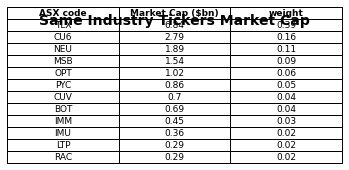

In [14]:
import matplotlib.pyplot as plt

# Create the plot
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust figure size as needed
ax.axis('tight')
ax.axis('off')

same_industry_tickers_mcap['Market Cap'] = same_industry_tickers_mcap['Market Cap'].apply(
    lambda x: round(x/1e9, 2))
same_industry_tickers_mcap.rename(
    columns={'Market Cap': 'Market Cap ($bn)'}, inplace=True)
same_industry_tickers_mcap['weight'] = same_industry_tickers_mcap['weight'].apply(
    lambda x: round(x, 2))


# Create a table in the plot
table = ax.table(cellText=same_industry_tickers_mcap.values,
                 colLabels=same_industry_tickers_mcap.columns,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title("Same Industry Tickers Market Cap", fontsize=14, fontweight='bold')

# Save the plot as an image
plt.savefig(f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [15]:
same_gics_industry_weight_dict = same_industry_tickers_mcap.set_index('ASX code')[
    'weight'].to_dict()

In [16]:
# TODO:
my_portfolio_tickers = [TICKER]
my_portfolio_tickers.extend([ticker.split('.')[
                            0] for ticker in comparable_tickers['list'] if ticker.split('.')[0] != TICKER])
my_portfolio_tickers.extend(index_tickers)

historical_prices = get_historical_prices(
    my_portfolio_tickers, index_tickers, historical_prices)

$LTP.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$CU6.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$LTP.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")
$CU6.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")
$LTP.AX: possibly delisted; no price data found  (1d 2021-01-01 -> 2021-12-31) (Yahoo error = "Data doesn't exist for startDate = 1609419600, endDate = 1640869200")
$LTP.AX: possibly delisted; no price data found  (1d 2022-01-01 -> 2022-12-31) (Yahoo error = "Data doesn't exist for startDate = 1640955600, endDate = 1672405200")


In [17]:
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    monthly_returns_df_dict[ticker] = get_return(price_df, 'M')

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    quarterly_returns_df_dict[ticker] = get_return(price_df, 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    yearly_returns_df_dict[ticker] = get_return(price_df, 'Y')

In [18]:
monthly_returns_df_dict = get_gics_industry_weighted_mean(
    monthly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'M', comparable_tickers=comparable_tickers)
quarterly_returns_df_dict = get_gics_industry_weighted_mean(
    quarterly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'Q', comparable_tickers=comparable_tickers)
yearly_returns_df_dict = get_gics_industry_weighted_mean(
    yearly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'Y', comparable_tickers=comparable_tickers)

In [19]:
stats_dict = {}

for ticker in monthly_returns_df_dict:
    stats_dict[ticker] = get_stats(
        monthly_returns_df_dict, ticker, first_end_of_quarter, last_end_of_quarter)

stats_df = pd.DataFrame(stats_dict).T

In [20]:
same_gics_stats_df = stats_df[~stats_df.index.isin(
    index_tickers + [TICKER, 'GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean'])]

In [21]:
same_gics_stats_df['ASX code'] = same_gics_stats_df.index

same_gics_stats_df = same_gics_stats_df.merge(
    same_industry_tickers_mcap, on='ASX code')

In [22]:
# get weighted means of each column
weighted_mean_dict = {}
for col in same_gics_stats_df.columns:
    if col in ['ASX code', 'weight']:
        continue
    weighted_mean_dict[col] = np.average(
        same_gics_stats_df[col], weights=same_gics_stats_df['weight'])

weighted_mean_df = pd.DataFrame(weighted_mean_dict, index=[
                                'GICS I.WMean (Macro)' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean (Macro)'])
weighted_mean_df

stats_df = pd.concat(
    [stats_df, weighted_mean_df.drop(columns=['Market Cap ($bn)'])])
stats_df

,mean (%),std (%),n,sharpe,CAPM beta,CAPM alpha
CSL,0.350000,5.030000,49.000000,0.240000,0.430000,0.530000
BOT,6.640000,24.940000,49.000000,0.920000,2.710000,3.730000
CU6,5.830000,21.430000,34.000000,0.940000,1.540000,5.550000
CUV,-0.150000,12.510000,49.000000,-0.040000,0.710000,-0.850000
IMM,2.580000,18.390000,49.000000,0.490000,2.030000,1.430000
IMU,6.060000,38.890000,49.000000,0.540000,3.080000,5.030000
LTP,22.570000,56.170000,6.000000,1.390000,-6.170000,33.500000
MSB,0.520000,26.470000,49.000000,0.070000,2.800000,2.620000
NEU,7.500000,24.970000,49.000000,1.040000,2.430000,5.120000
OPT,-2.870000,16.810000,49.000000,-0.590000,0.670000,4.790000


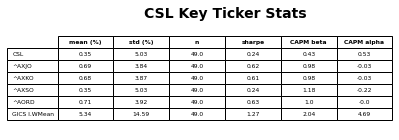

In [23]:
import matplotlib.pyplot as plt

# Assuming key_ticker_stats is already created from your DataFrame
key_ticker_stats = stats_df.loc[[TICKER, '^AXJO',
                                 '^AXKO', '^AXSO', '^AORD'] + ['GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean']]

# Create the plot
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=key_ticker_stats.values,
                 colLabels=key_ticker_stats.columns,
                 rowLabels=key_ticker_stats.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Ticker Stats", fontsize=14, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_key_ticker_stats_table.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [24]:
ticker_mv['Market Cap ($bn)'].values[0] / \
    weighted_mean_df['Market Cap ($bn)'].values[0]

39.40822975414774

In [25]:
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, first_end_of_quarter, last_end_of_quarter)

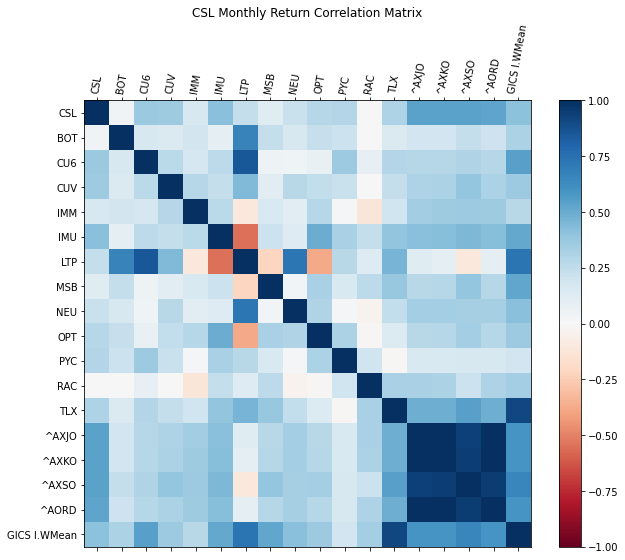

In [26]:
plot_correlation(correlation_df, ticker=TICKER)

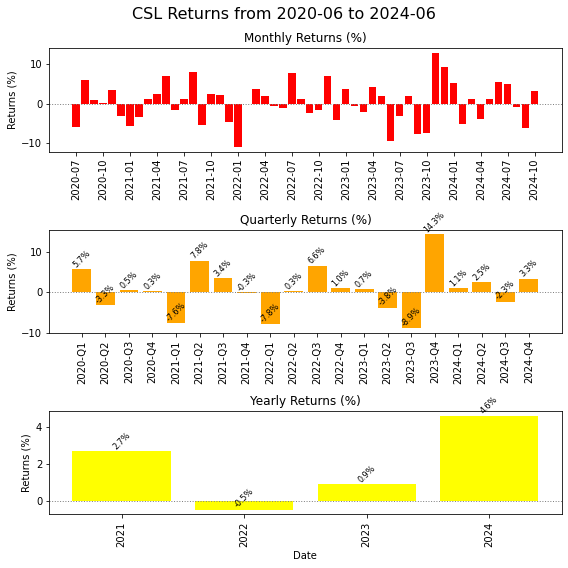

In [27]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': TICKER,
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

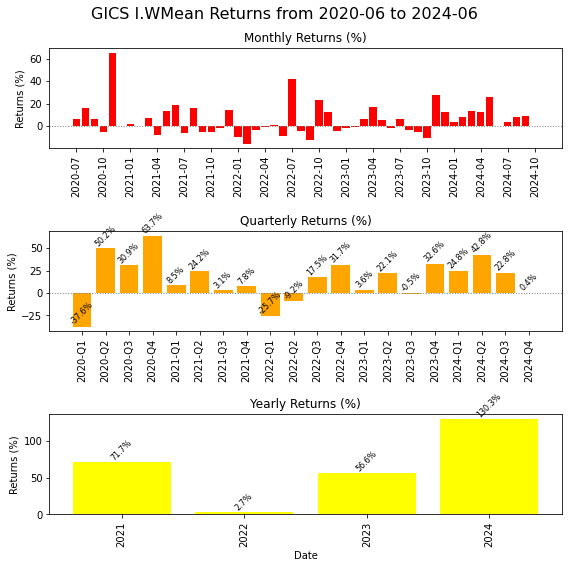

In [28]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict,
                'ticker': 'GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter,
                'underlying_ticker': TICKER})

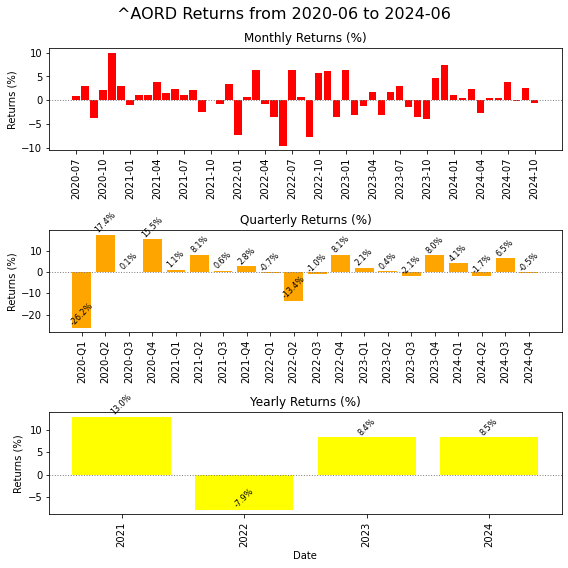

In [29]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': '^AORD',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

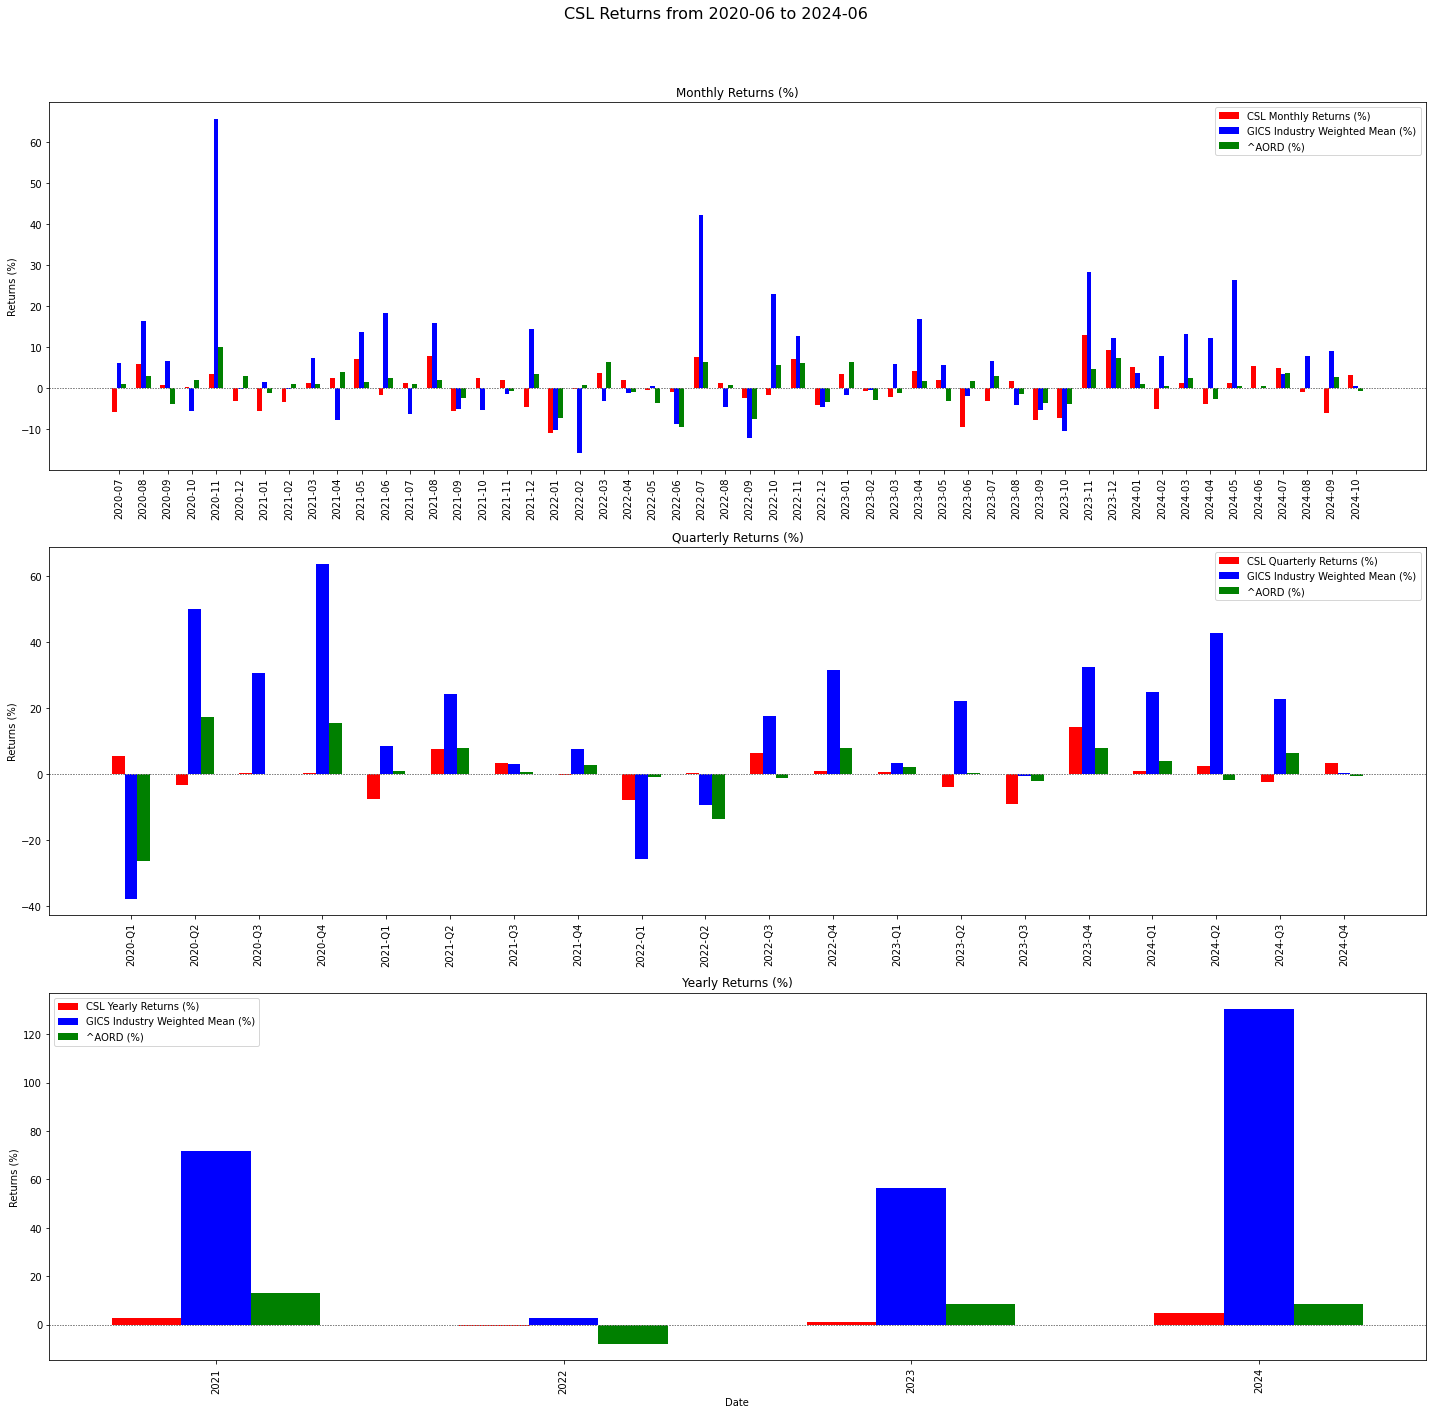

In [30]:
plot_returns_comparative(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                            'quarterly_returns_df_dict': quarterly_returns_df_dict,
                            'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER,
                            'first_end_of_quarter': first_end_of_quarter,
                            'last_end_of_quarter': last_end_of_quarter,
                            'comparable_tickers': comparable_tickers})

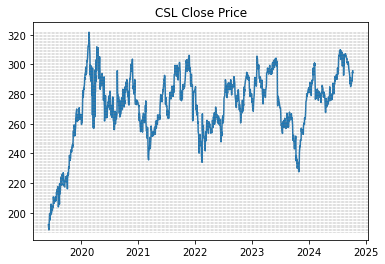

In [31]:
plot_close_price_with_dollar_lines(TICKER, historical_prices)

In [32]:
# Convert date to AEST directly using tz_convert, since the index is already timezone-aware
historical_dividends = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()

# Ensure the 'Date' column is in datetime format
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])

# Convert the 'Date' column to AEST
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone unaware but still a timestamp
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Display the dividends greater than 0 with the adjusted 'Date' column
display(historical_dividends[historical_dividends['Dividends'] > 0][[
        'Date', 'Dividends']])

,Date,Dividends
70,2019-09-10,1.454545
196,2020-03-11,1.471271
324,2020-09-10,1.469578
444,2021-03-04,1.349073
571,2021-09-02,1.589654
698,2022-03-07,1.422903
825,2022-09-06,1.758307
952,2023-03-09,1.621458
1080,2023-09-11,2.007782
1206,2024-03-11,1.798942


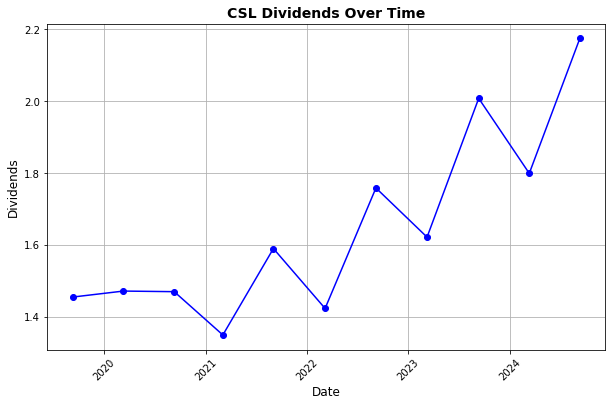

In [33]:
# Assuming historical_dividends is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_dividends = historical_prices[TICKER]
# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Filter the data to include only the rows where Dividends are greater than 0
dividends_df = historical_dividends[historical_dividends['Dividends'] > 0][[
    'Date', 'Dividends']]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Dividends
ax.plot(dividends_df['Date'], dividends_df['Dividends'],
        marker='o', linestyle='-', color='b')

# Set the title and labels
ax.set_title(f'{TICKER} Dividends Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Dividends', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax.grid(True)

# Save the plot as an image if needed
plt.savefig(f'../outputs/{TICKER}_dividends_over_time.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [34]:
# Convert date to AEST directly using tz_convert, since the index is already timezone-aware
historical_splits = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_splits = historical_splits.reset_index()

# Ensure the 'Date' column is in datetime format
historical_splits['Date'] = pd.to_datetime(historical_splits['Date'])

# Convert the 'Date' column to AEST
historical_splits['Date'] = historical_splits['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone unaware but still a timestamp
historical_splits['Date'] = historical_splits['Date'].dt.tz_localize(
    None)

# Display the dividends greater than 0 with the adjusted 'Date' column
display(historical_splits[historical_splits['Stock Splits'] > 0][[
        'Date', 'Stock Splits']])

,Date,Stock Splits


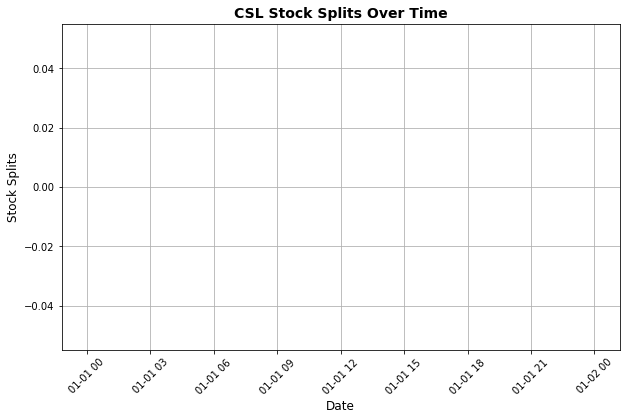

In [35]:
# Assuming historical_splits is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_splits = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_splits = historical_splits.reset_index()

# Ensure the 'Date' column is in datetime format
historical_splits['Date'] = pd.to_datetime(historical_splits['Date'])

# Convert the 'Date' column to AEST
historical_splits['Date'] = historical_splits['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone-unaware but still a timestamp
historical_splits['Date'] = historical_splits['Date'].dt.tz_localize(None)

# Filter the data to include only the rows where Stock Splits are greater than 0
splits_df = historical_splits[historical_splits['Stock Splits'] > 0][[
    'Date', 'Stock Splits']]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Stock Splits
ax.plot(splits_df['Date'], splits_df['Stock Splits'],
        marker='o', linestyle='-', color='b')

# Set the title and labels
ax.set_title(f'{TICKER} Stock Splits Over Time',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Stock Splits', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax.grid(True)

# Save the plot as an image if needed
plt.savefig(f'../outputs/{TICKER}_stock_splits_over_time.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

- beta: need interest rate

In [36]:
pdf = FPDF()

# TITLE
# Add a page
pdf.add_page()
# Set font for the title
pdf.set_font("Arial", 'B', 16)  # Bold and size 16 for the title
title = f"Stock Analysis of Ticker: {TICKER}"
pdf.cell(200, 10, txt=title, ln=True, align='C')

# Comparable Ticker Universe
# Set font for the content
pdf.set_font("Arial", 'B', size=12)
pdf.cell(200, 10, txt=f"Comparable tickers universe", ln=True, align='L')
pdf.set_font("Arial", size=10)
text = f"{'same INDUSTRY of TOP500' if 'industry' in comparable_tickers['type'] else 'same SECTOR of MCAP$1BN+'}"
pdf.cell(200, 10, txt=text, ln=True, align='L')

# Retrieve and convert the Market Cap of the stock in question (from ticker_mv) to billions
ticker_market_cap_billion = round(
    ticker_mv.iloc[0]['Market Cap ($bn)'] / 1e9, 2)
ticker_proportion_of_market = ticker_mv['Market Cap ($bn)'].values[0] / \
    same_industry_tickers_mcap['Market Cap ($bn)'].sum()
universe_market_value_billion = round(
    same_industry_tickers_mcap['Market Cap ($bn)'].sum() / 1e9, 2)
pdf.cell(
    200, 10, txt=f"{TICKER} has a market value of ${ticker_market_cap_billion}B and is {round(ticker_proportion_of_market, 2)} times the universe market value of ${universe_market_value_billion}B,", align='L')
pdf.cell(
    200, 10, txt=f"{round(ticker_mv['Market Cap ($bn)'].values[0]/weighted_mean_df['Market Cap ($bn)'].values[0],2)} times the average stock MCap in the universe.", align='L')
pdf.ln()

# KEY STATS
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Key Stats", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(
    f'../outputs/{TICKER}_key_ticker_stats_table.png', x=10, y=None, w=125)

# COMPARATIVE RETURNS PLOTS
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Comparative Returns Plot", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_comparative_returns.png', x=10, y=None, w=150)

# TICKER RETURN CHART
pdf.add_page()  # Add a new page for the plot
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Returns Chart", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_returns.png', x=10, y=None, w=100)

# SECTOR/INDUSTRY WMEAN RETURNS CHART
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(
    200, 10, txt=f"{TICKER} Sector/Industry Weighted Mean Returns Chart", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_WMean_returns.png', x=10, y=None, w=100)

# ^AORD CHART
pdf.add_page()
pdf.set_font("Arial", 'B', 12)
pdf.cell(
    200, 10, txt=f"{TICKER} ^AORD Chart", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/^AORD_returns.png', x=10, y=None, w=100)

# CLOSE PRICE CHART
pdf.add_page()  # Add a new page for the plot
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Close Price Chart", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_close_price.png', x=10, y=None, w=75)

# DIVIDENDS
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(200, 10, txt=f"{TICKER} Dividends", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_dividends_over_time.png', x=10, y=None, w=75)

# APPENDIX
pdf.add_page()  # Add a new page for the appendix
# Set font for the title
pdf.set_font("Arial", 'B', 12)  # Bold and size 16 for the title

# APPENDIX TITLE
title = f"Appendix"
pdf.cell(200, 10, txt=title, ln=True, align='C')

# CORRELATION
pdf.set_font("Arial", 'B', 12)
pdf.cell(200, 10, txt=f"{TICKER} Correlation Matrix Plot", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(f'../outputs/{TICKER}_correlation_matrix.png', x=10, y=None, w=140)

# SPLITS
pdf.set_font("Arial", 'B', 12)
pdf.cell(200, 10, txt=f"{TICKER} Splits", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(
    f'../outputs/{TICKER}_stock_splits_over_time.png', x=10, y=None, w=75)

# INDUSTRY TICKER MCAP TABLE
pdf.add_page()
pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
pdf.cell(
    200, 10, txt=f"{TICKER} Same Sector/Industry Ticker MCAP Table", ln=True, align='L')
pdf.ln(5)  # Line break before adding the image
pdf.image(
    f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png', x=10, y=None, w=75)

# Save the PDF after adding the image
pdf.output(f"../reports/{TICKER}_comparable_tickers_report_with_plot.pdf")

''

In [37]:
assert False

AssertionError: 

# Other Stats

In [ ]:
TICKER = 'NVX'

In [ ]:
object = yf.Ticker(f'{TICKER}.AX')

In [ ]:
balance_sheet_row = [
    'Total Debt',  # total debt
    'Stockholders Equity',  # total equity & book value
    'Share Issued',  # n shares
]
balance_sheet = object.balance_sheet.loc[balance_sheet_row]

In [ ]:
cashflow_row = [
    'Free Cash Flow',  # cashflow
    'End Cash Position'  # cash
]

cashflows = object.cashflow.loc[cashflow_row]

In [ ]:
financial_row = [
    'EBIT',
    'Gross Profit',  # profit
    'Total Revenue'  # revenue
]

financials = object.financials.loc[financial_row]

In [ ]:
stock_fundementals = pd.concat([balance_sheet, cashflows, financials]).T
# sort the rows by index
stock_fundementals = stock_fundementals.sort_index()

In [ ]:
stock_fundementals['EPS'] = stock_fundementals['EBIT'] / \
    stock_fundementals['Share Issued']
stock_fundementals['D/E'] = stock_fundementals['Total Debt'] / \
    stock_fundementals['Stockholders Equity']
stock_fundementals['Book Value Per Share'] = stock_fundementals['Stockholders Equity'] / \
    stock_fundementals['Share Issued']

In [ ]:
# if whole row is NaN, drop it
stock_fundementals = stock_fundementals.dropna(how='all')

In [ ]:
stock_fundementals

,Total Debt,Stockholders Equity,Share Issued,Free Cash Flow,End Cash Position,EBIT,Gross Profit,Total Revenue,EPS,D/E,Book Value Per Share
2020-06-30,NaN,NaN,NaN,-7426208.0,26690276.0,-11072623.0,2016403.0,2851035.0,NaN,NaN,NaN
2021-06-30,10356322.0,138449834.0,404601384.0,-25664712.0,102601252.0,-13305925.0,3083075.0,3893739.0,-0.032887,0.074802,0.342188
2022-06-30,42309006.0,251133478.0,485951369.0,-113019442.0,142737362.0,-50391738.0,4376530.0,6101155.0,-0.103697,0.168472,0.516787
2022-12-31,41341840.0,226056269.0,486774622.0,NaN,NaN,NaN,NaN,NaN,NaN,0.182883,0.464396
2023-12-31,69387750.0,183936275.0,488733461.0,-55424219.0,78713885.0,-43602661.0,5237259.0,8054528.0,-0.089216,0.377238,0.376353


In [ ]:
# gross margin = gross profit / total revenue
# net margin = ebit / total revenue

# interest coverage: ebit / interest expense (or finance cost)

# TODO:



Need to calculate:
- multiples
    - needs a price
- percentage change

- (after confirm all our multiples) want to get average of peers, weighted. 

- peer weighted first part growth.

Challenges:
- different dates of report (june 30th or dec 31st) (challenge for calculating percentage growth)

- nans occuring in different places (challenge for calculating percentage growth)

- engineering problem: 
    - getting stock data takes quite a long time... (first part)
    

Presentation:
- present it in a pdf report